In [25]:
import time
from dill import dump_session, load_session
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, metrics
import scipy.stats as st

start_time = time.time()

### One-hot-encoding for categorical attributes

In [26]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)

# dropped_attributes = ['instant','dteday','yr','mnth','holiday','weekday','casual','registered']
dropped_attributes = ['instant','dteday','yr','mnth','holiday','weekday']
for attribute in dropped_attributes:
    df = df.drop(attribute, axis=1)
    
# One hot encoding
ohe_df = pd.get_dummies(df, columns = ['season','weathersit'])
ohe_df = ohe_df.drop(['season_4','weathersit_3'], axis=1)    # season_4, weathersit_3 are chosen as reference variables
display(ohe_df)

,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,1,0,0,0,1
1,0,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0,0,0,1
2,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1,0,0,1,0
3,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1,0,0,1,0
4,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,1,0,0,0,1
727,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,1,0,0,0,1
728,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,1,0,0,0,1
729,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,1,0,0,1,0


### Standardize data

In [27]:
N, M = ohe_df.shape
attribute_names = list(ohe_df.columns)

# Get column indexes
temp_col = ohe_df.columns.get_loc("temp")
atemp_col = ohe_df.columns.get_loc("atemp")
hum_col = ohe_df.columns.get_loc("hum")
wspd_col = ohe_df.columns.get_loc("windspeed")
cnt_col = ohe_df.columns.get_loc("cnt")

# Undo the original max-min normalization
data = ohe_df.values
for row in range(0, N):
    data[row, temp_col] = data[row, temp_col]*(39-(-8)) + (-8)
    data[row, atemp_col] = data[row, atemp_col]*(50-(-16)) + (-16)
    data[row, hum_col] = data[row, hum_col]*100
    data[row, wspd_col] = data[row, wspd_col]*67

# Standarize ratio data attributes
for col in range(temp_col, cnt_col+1): # subtract mean column-wise
    mn = data[:, col].mean(0)
    std = np.std(data[:, col])
    data[:, col] = (data[:, col] - np.ones(N)*mn)/std

# Create DataFrame for visualisation
data_df = pd.DataFrame(data, columns=attribute_names)
display(data_df)

,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-0.753734,-1.925471,-1.817953,1.0,0.0,0.0,0.0,1.0
1,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.045214,-1.915209,-1.912999,1.0,0.0,0.0,0.0,1.0
2,1.0,-1.634657,-1.749767,-1.339274,0.746632,-1.061246,-1.556689,-1.629925,1.0,0.0,0.0,1.0,0.0
3,1.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.078734,-1.412383,-1.519898,1.0,0.0,0.0,1.0,0.0
4,1.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.116627,-1.371336,-1.500269,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,-1.318665,-1.521108,0.175807,2.061426,-0.876156,-1.147502,-1.234757,1.0,0.0,0.0,0.0,1.0
727,1.0,-1.323224,-1.346690,-0.266238,-0.452131,-0.297567,-0.772948,-0.728012,1.0,0.0,0.0,0.0,1.0
728,0.0,-1.323224,-1.424344,0.878392,-0.853552,-1.004407,-1.586833,-1.634057,1.0,0.0,0.0,0.0,1.0
729,0.0,-1.309558,-1.490049,-1.015664,2.069444,-0.705640,-1.426493,-1.399023,1.0,0.0,0.0,1.0,0.0


### Set 'workingday' as target variable

In [28]:
# Split dataset into features and target vector
workingday = attribute_names.index("workingday")
y = data[:,workingday]
X = np.delete(data, workingday, axis=1)
attribute_names.pop(workingday)
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attribute_names = [u'offset']+attribute_names
M = M+1

print("N: {}, M: {} (including offset)".format(N,M))

N: 731, M: 13 (including offset)


In [29]:
attribute_names

['offset',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'season_1',
 'season_2',
 'season_3',
 'weathersit_1',
 'weathersit_2']

### 1. Regularized Logistic Regression

In [30]:
# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

### 2. K-Nearest-Neighbours 

In [31]:
# Number of neighbours
k_values = list(range(1,11))
dist = 2
metric = 'minkowski'
metric_params = {}  # no parameters needed for minkowski

### Cross Validation

In [32]:
# Cross validation
K_outer = 10
K_inner = 10

cv_outer = model_selection.KFold(K_outer, shuffle=True, random_state=7)
cv_inner = model_selection.KFold(K_inner, shuffle=True, random_state=7)

In [33]:
# Initialize variables
Error_test_rlr = np.empty((K_outer,1))
Error_test_base = np.empty((K_outer,1))
opt_lambdas = np.empty((K_outer,1))             # optimal lambdas for each outer fold

Error_test_KNN = np.empty((K_outer,1))
opt_k_values = np.empty((K_outer,1))             # optimal neighbours for each outer fold

mu = np.empty((K_outer, M-1))
sigma = np.empty((K_outer, M-1))

# Statistical evaluation
y_hat = np.zeros((1,3))       # estimates for each model [ANN, rlr, baseline], to delete 1st row at the end
y_true = np.zeros((1))

### Training and Testing


Outer Cross Validation Fold: 1/10

	Inner Fold: 1/10

	Inner Fold: 2/10

	Inner Fold: 3/10

	Inner Fold: 4/10

	Inner Fold: 5/10

	Inner Fold: 6/10

	Inner Fold: 7/10

	Inner Fold: 8/10

	Inner Fold: 9/10

	Inner Fold: 10/10
Optimal lambda found:  -0.75758
Optimal k found:  4

Outer Cross Validation Fold: 2/10

	Inner Fold: 1/10

	Inner Fold: 2/10

	Inner Fold: 3/10

	Inner Fold: 4/10

	Inner Fold: 5/10

	Inner Fold: 6/10

	Inner Fold: 7/10

	Inner Fold: 8/10

	Inner Fold: 9/10

	Inner Fold: 10/10
Optimal lambda found:  -0.89899
Optimal k found:  5

Outer Cross Validation Fold: 3/10

	Inner Fold: 1/10

	Inner Fold: 2/10

	Inner Fold: 3/10

	Inner Fold: 4/10

	Inner Fold: 5/10

	Inner Fold: 6/10

	Inner Fold: 7/10

	Inner Fold: 8/10

	Inner Fold: 9/10

	Inner Fold: 10/10
Optimal lambda found:  -0.89899
Optimal k found:  5

Outer Cross Validation Fold: 4/10

	Inner Fold: 1/10

	Inner Fold: 2/10

	Inner Fold: 3/10

	Inner Fold: 4/10

	Inner Fold: 5/10

	Inner Fold: 6/10

	Inner Fold: 7/1

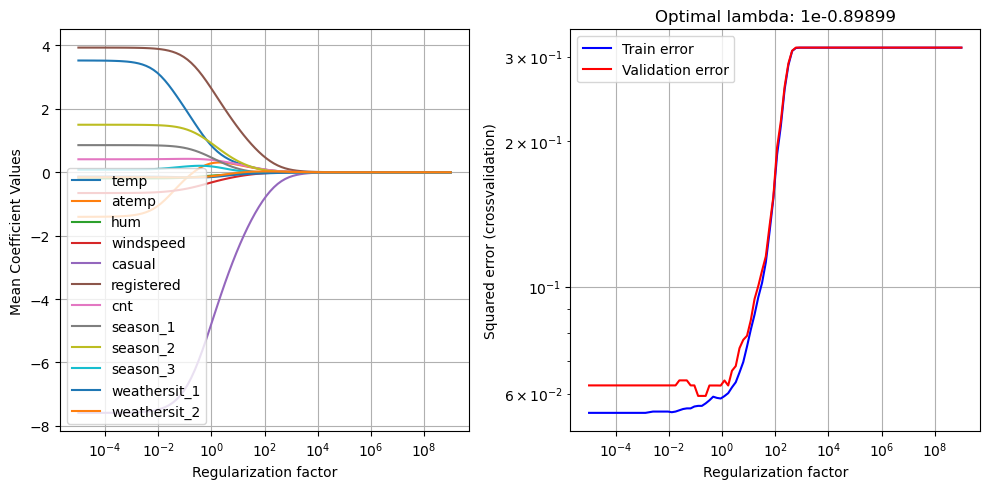

In [39]:
for k_out, (par_index, test_index) in enumerate(cv_outer.split(X,y)):
    
    print('\nOuter Cross Validation Fold: {0}/{1}'.format(k_out+1,K_outer))
    
    # Split outer fold into parameterisation set and test set
    X_par = X[par_index]
    y_par = y[par_index].astype(int)
    X_test = X[test_index]
    y_test = y[test_index].astype(int)
    y_par = y_par.squeeze()
    
    # Initialise error arrays
    w = np.empty((M,K_inner,len(lambdas)))           
    lr_train_error = np.empty((K_inner,len(lambdas)))
    lr_val_error = np.empty((K_inner,len(lambdas)))    
    coefficient_norm = np.empty((K_inner,len(lambdas)))   
    
    knn_train_error = np.empty((K_inner,len(k_values)))
    knn_val_error = np.empty((K_inner,len(k_values)))    
    
    for k_in, (train_index, val_index) in enumerate(cv_inner.split(X_par,y_par)):
    
        print('\n\tInner Fold: {}/{}'.format(k_in+1,K_inner))
        
        # Split parameterisation set into training set and validation set
        X_train = X[train_index]
        y_train = y[train_index].astype(int)
        X_val = X[val_index]
        y_val = y[val_index].astype(int)
    
        ########################### Logistic Regression ###########################
        # Standardize inner fold based on training set, and save the mean and std
        mu_train = np.mean(X_train[:, 1:], 0)
        sigma_train = np.std(X_train[:, 1:], 0)
        X_train[:, 1:] = (X_train[:, 1:] - mu_train) / sigma_train
        X_val[:, 1:] = (X_val[:, 1:] - mu_train) / sigma_train

        # solve for weights
        for l in range(0,len(lambdas)):
            mdl = LogisticRegression(penalty='l2', C=1/lambdas[l] )
            mdl.fit(X_train, y_train)
            
            y_train_est = mdl.predict(X_train).T.astype(int)
            y_val_est = mdl.predict(X_val).T.astype(int)
                    
            # Evaluate training and validation performance
            lr_train_error[k_in,l] = np.sum(y_train_est != y_train) / len(y_train)
            lr_val_error[k_in,l] = np.sum(y_val_est != y_val) / len(y_val)

            w_est = mdl.coef_[0]
            w[:,k_in,l] = w_est
#             w[:,k_in,l] = np.sqrt(np.sum(w_est**2))
        
        for k_i in range(0,len(k_values)):
            knclassifier = KNeighborsClassifier(n_neighbors=k_values[k_i], p=dist,
                                    metric=metric,
                                    metric_params=metric_params)
            knclassifier.fit(X_train, y_train)
            
            y_train_est = knclassifier.predict(X_train)
            y_val_est = knclassifier.predict(X_val)
            
            # Evaluate training and validation performance
            knn_train_error[k_in,k_i] = np.sum(y_train_est != y_train) / len(y_train)
            knn_val_error[k_in,k_i] = np.sum(y_val_est != y_val) / len(y_val)

    ########################### Logistic Regression ###########################
    opt_val_err = np.min(lr_val_error)
    opt_lambda = lambdas[np.argmin(np.mean(lr_val_error,axis=0))]
    opt_lambdas[k_out] = opt_lambda
    print("Optimal lambda found: ", round(np.log10(opt_lambda),5))
   
    train_err_vs_lambda = np.mean(lr_train_error,axis=0)
    val_err_vs_lambda = np.mean(lr_val_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))

    # Retrain logistic regression model on parameterisation set using optimal lambda
    mdl = LogisticRegression(penalty='l2', C=1/opt_lambda )
    mdl.fit(X_par, y_par)

    # y_par_est = mdl.predict(X_par).T.astype(int)
    y_test_est = mdl.predict(X_test).T.astype(int)

    # Evaluate test performance of logistic regression model
    Error_test_rlr[k_out] = np.sum(y_test_est != y_test) / len(y_test)
    
    ########################### Baseline Model ###########################
    majority_class = np.bincount(y_test).argmax()
    Error_test_base[k_out] = np.sum(y_test != majority_class) / len(y_test)
    
    ################################ KNN #################################
    opt_k_err = np.min(knn_val_error)
    opt_k = k_values[np.argmin(np.mean(knn_val_error,axis=0))]
    opt_k_values[k_out] = opt_k
    print("Optimal k found: ", opt_k)
    
    # Retrain KNN model on parameterisation set using optimal lambda
    knclassifier = KNeighborsClassifier(n_neighbors=opt_k, p=dist,
                                    metric=metric,
                                    metric_params=metric_params)
    knclassifier.fit(X_par, y_par)
    y_test_est = knclassifier.predict(X_test)
    
    # Evaluate test performance of KNN model
    Error_test_KNN[k_out] = np.sum(y_test_est != y_test) / len(y_test)
    
   # Display the results for the last outer cross-validation fold
    if k_out == K_outer-1:
        reg_fig, reg_axes = plt.subplots(1, 2, figsize=(10,5),num=1)
        reg_axes[0].semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-',label=attribute_names[1:]) # Don't plot the bias term
        reg_axes[0].set_xlabel('Regularization factor')
        reg_axes[0].set_ylabel('Mean Coefficient Values')
        reg_axes[0].grid()
        reg_axes[0].legend()

        reg_axes[1].set_title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambdas[k_out][0]),5)))
        reg_axes[1].loglog(lambdas,train_err_vs_lambda.T,'b-',lambdas,val_err_vs_lambda.T,'r-')
        reg_axes[1].set_xlabel('Regularization factor')
        reg_axes[1].set_ylabel('Squared error (crossvalidation)')
        reg_axes[1].legend(['Train error','Validation error'])
        reg_axes[1].grid()
        reg_fig.tight_layout()


### Results of Linear Regression

In [ ]:
# # Bar plot of RLR weights
# weights = range(1,M)      # skip offset
# bw = 1.0/(len(weights)+1)
# r = np.arange(1,K_outer+1)

# plt.figure(figsize=(6,6), num=3)
# for i in weights:
#     plt.bar(r+i*bw, w[i,:], width=bw)
# plt.xticks(r+bw, range(1,K_outer+1))
# plt.xlabel('Attributes')
# plt.ylabel('Weights')
# plt.legend(attribute_names[1:M+1], loc=(1.04, 0))
# plt.grid()
# plt.title('Weights from each fold of Regularized Linear Regression')

### Table 2

In [42]:
print("Outer fold \tKNN \t\t\tLogistic Regression \t\tBaseline")
print("--------------------------------------------------------------------------------")
print("i \t\tk_i \tEtest_i \tlambda_i \tEtest_i \tEtest_i")
for i in range(K_outer):
    print("{} \t\t{:.3f} \t{:.3f} \t\t1e{} \t{:.5f} \t{:.5f}".format(\
        i+1,opt_k_values[i][0],Error_test_KNN[i].item(),round(np.log10(opt_lambdas[i][0]),3),\
            Error_test_rlr[i][0],Error_test_base[i][0]))

Outer fold 	KNN 			Logistic Regression 		Baseline
--------------------------------------------------------------------------------
i 		k_i 	Etest_i 	lambda_i 	Etest_i 	Etest_i
1 		4.000 	0.095 		1e-0.758 	0.10811 	0.37838
2 		5.000 	0.082 		1e-0.899 	0.02740 	0.28767
3 		5.000 	0.151 		1e-0.899 	0.04110 	0.30137
4 		5.000 	0.178 		1e-0.899 	0.05479 	0.21918
5 		5.000 	0.123 		1e-0.899 	0.06849 	0.31507
6 		5.000 	0.137 		1e-0.899 	0.05479 	0.26027
7 		5.000 	0.178 		1e-0.899 	0.06849 	0.31507
8 		5.000 	0.137 		1e-0.899 	0.12329 	0.35616
9 		5.000 	0.096 		1e-0.899 	0.08219 	0.43836
10 		5.000 	0.123 		1e-0.899 	0.06849 	0.28767


## Statistical Evaluation

In [ ]:
def compute_CI(zA, zB, mA_name, mB_name, alpha=0.05,):
    print("\nComparing {} and {}:".format(mA_name,mB_name))
    
    # compute confidence interval of model A and B
    alpha = 0.05
    CI_A = st.t.interval(1-alpha, df=len(zA)-1, loc=np.mean(zA), scale=st.sem(zA))  # Confidence interval
    CI_B = st.t.interval(1-alpha, df=len(zB)-1, loc=np.mean(zB), scale=st.sem(zB))  # Confidence interval
    print("\tCI for {}: {}".format(mA_name, CI_A))
    print("\tCI for {}: {}".format(mB_name, CI_B))

    # Compute confidence interval of z = zA-zB and p-value of Null hypothesis
    z = zA - zB
    CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
    p = 2*st.t.cdf(-np.abs( np.mean(z))/st.sem(z), df=len(z)-1)  # p-value
    print("\tCI : ", CI)
    print("\tp: ", p)

In [ ]:
# compute z with squared error.
zKNN = np.abs(y_true - y_hat[:,0] ) ** 2
zRLR = np.abs(y_true - y_hat[:,1] ) ** 2
zBase = np.abs(y_true - y_hat[:,2] ) ** 2

alpha = 0.05
compute_CI(zKNN, zRLR, 'KNN', 'RLR', alpha)
compute_CI(zKNN, zBase, 'KNN', 'Baseline', alpha)
compute_CI(zRLR, zBase, 'RLR', 'Baseline', alpha)

## Housekeeping

In [ ]:
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# dump_session('sun_night_2_env.db')
# dill.load_session('friday_2234_env.db')

## Saved Results Below